In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
keras = tf.keras
from datetime import datetime

from typing import List

import os
import glob

from src.io.load import DataLoader

from dataclasses import dataclass, field
from typing import Dict
from src.action_strategy.factory import ActionStrategy
from src.action_strategy.mean_reversion import MeanReversion
from src.forecast.factory import ModelForecastFactory
from src.forecast.runner import ForecastRunner
from src.forecast.utils import SamplerSetForecast
from src.io.load import DataLoader, load_config
from src.io.save import Dumper
from src.preprocessing.preprocess import ProcessData
from src.stock import Balance, Stock
import logging
from src.trade_manager import TradeManagerV0
from datetime import datetime, timedelta
import math
from abc import ABC, abstractmethod

In [3]:
PATH_DATA_PROCESSED = "../data/processed/"

In [4]:
import logging
from src.main import load_config, load_data, Experiment

In [5]:
logging.basicConfig()
log=logging.getLogger(__name__)
log.setLevel(logging.DEBUG)

### Load data

In [6]:
config_file = "1"
# Load config and data
logging.info("Load data and config..")
config_exp = load_config(config_file)
prices = load_data(config_exp["market_name"])
config_exp["date_start"] =  datetime.strptime(' '.join([config_exp["date_start"], config_exp["hour_begin_trade"]]), "%d-%m-%Y %H")
config_exp["date_end"] =  datetime.strptime(' '.join([config_exp["date_end"], config_exp["hour_begin_trade"]]), "%d-%m-%Y %H")

n_days = (config_exp["date_end"] - config_exp["date_start"]).days
config_exp["n_iteration"] = math.ceil(n_days/config_exp["n_frames"])

logging.info("Process data ..")
prices = ProcessData(df=prices).run_preprocess()
prices = prices.to_frame("value")


prices = prices[~prices.value.isna()]

In [7]:
config_exp

{'storage_cpty': 956,
 'storage_pwr': 100,
 'rho_d': 0.86,
 'rho_s': 0.86,
 'eta': 0.7,
 't_discharge': 8,
 'balance_init_level': 1000,
 'init_storage_cpty': 0,
 'market_name': 'germany',
 'date_start': datetime.datetime(2021, 1, 1, 13, 0),
 'date_end': datetime.datetime(2021, 1, 3, 13, 0),
 'hour_begin_trade': '13',
 'alpha': 0.7,
 'period': 23,
 'n_frames': 24,
 'n_iteration': 1}

### Init model

In [8]:
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from src.forecast.utils import SamplerSetForecast
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [9]:
#ridge = {"f_forecast","mode":Ridge()}
ridge = Ridge()
lgbm = LGBMRegressor([])

In [10]:
LGBMRegressor()

LGBMRegressor()

In [11]:
data = prices.loc[:pd.datetime(2021, 1, 1)].copy()

/tmp/ipykernel_7251/3241595181.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  data = prices.loc[:pd.datetime(2021, 1, 1)].copy()


In [146]:
current = ModelForecastFactory().get_model(**{
                                            "name":"arima",
                                            "order":dict(p=24, d=1, q=0),
                                            "seasonal_order":None,
                                            })

In [13]:
model_list = []

### Create features

In [59]:
data = prices.copy()


In [60]:
data['week_day'] = data.index.day_of_week+1

In [61]:
data['month'] = data.index.month

In [62]:
data.shape

(26280, 3)

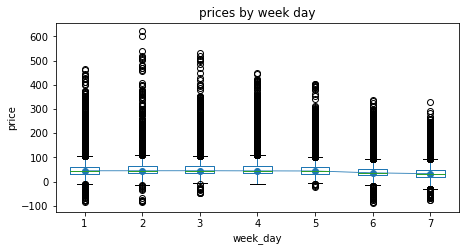

In [63]:
fig, ax = plt.subplots(figsize=(7, 3.5))
data.boxplot(column='value', by='week_day', ax=ax)
data.groupby('week_day')['value'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('price')
ax.set_title('prices by week day')
fig.suptitle('');


In [64]:
lags_features = 24*7
for i in range(1, lags_features+1):
    data['t_{}'.format(i)] = data['value'].shift(i)

/tmp/ipykernel_7251/1647617307.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['t_{}'.format(i)] = data['value'].shift(i)
/tmp/ipykernel_7251/1647617307.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['t_{}'.format(i)] = data['value'].shift(i)
/tmp/ipykernel_7251/1647617307.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragme

In [65]:
data["weekend"] = np.where(data["week_day"].isin([6, 7]), 1, 0)

/tmp/ipykernel_7251/2041328870.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["weekend"] = np.where(data["week_day"].isin([6, 7]), 1, 0)


In [66]:
data.index.hour

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
           dtype='int64', name='time', length=26280)

/tmp/ipykernel_7251/1542258855.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["hour"] = data.index.hour
/tmp/ipykernel_7251/1542258855.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['hour_sin'] = np.sin(data['hour'] / 23 * 2 * np.pi)
/tmp/ipykernel_7251/1542258855.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

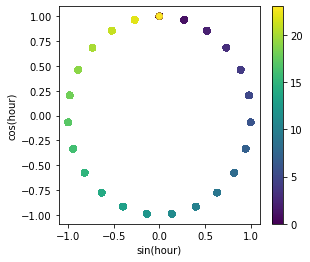

In [67]:
data["hour"] = data.index.hour
data['hour_sin'] = np.sin(data['hour'] / 23 * 2 * np.pi)
data['hour_cos'] = np.cos(data['hour'] / 23 * 2 * np.pi)

# Plot of the transformation
# ==============================================================================
fig, ax = plt.subplots(figsize=(4.5, 4))
sp = ax.scatter(data["hour_sin"], data["hour_cos"], c=data["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

data = data.drop(columns='hour')

In [68]:
data = data.drop("week_day", axis=1)

In [69]:
data = data.dropna()

In [70]:
data.shape

(26112, 173)

In [75]:
n_frames=48
idx = int(len(data)*0.8)
x_train = data[:idx].drop("value", axis=1)
y_train = data[:idx]["value"]
x_test = data[idx:(idx+n_frames)].drop("value", axis=1)
y_test = data[idx:(idx+n_frames)]["value"]


In [76]:
lgbm.fit(x_train, y_train)

LGBMRegressor(boosting_type=[])

In [77]:
x_train.shape

(20889, 172)

In [78]:
x_test

,month,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_162,t_163,t_164,t_165,t_166,t_167,t_168,weekend,hour_sin,hour_cos
time,,,,,,,,,,,,,,,,,,,,,
2021-05-28 09:00:00,5,80.09,84.38,92.42,93.01,81.36,67.93,64.64,62.03,61.59,...,16.01,2.33,-5.83,-9.47,0.67,13.99,22.45,0,6.310879e-01,-0.775711
2021-05-28 10:00:00,5,79.03,80.09,84.38,92.42,93.01,81.36,67.93,64.64,62.03,...,47.57,16.01,2.33,-5.83,-9.47,0.67,13.99,0,3.984011e-01,-0.917211
2021-05-28 11:00:00,5,73.29,79.03,80.09,84.38,92.42,93.01,81.36,67.93,64.64,...,60.23,47.57,16.01,2.33,-5.83,-9.47,0.67,0,1.361666e-01,-0.990686
2021-05-28 12:00:00,5,60.61,73.29,79.03,80.09,84.38,92.42,93.01,81.36,67.93,...,63.92,60.23,47.57,16.01,2.33,-5.83,-9.47,0,-1.361666e-01,-0.990686
2021-05-28 13:00:00,5,58.34,60.61,73.29,79.03,80.09,84.38,92.42,93.01,81.36,...,58.80,63.92,60.23,47.57,16.01,2.33,-5.83,0,-3.984011e-01,-0.917211
2021-05-28 14:00:00,5,60.00,58.34,60.61,73.29,79.03,80.09,84.38,92.42,93.01,...,55.10,58.80,63.92,60.23,47.57,16.01,2.33,0,-6.310879e-01,-0.775711
2021-05-28 15:00:00,5,61.02,60.00,58.34,60.61,73.29,79.03,80.09,84.38,92.42,...,42.69,55.10,58.80,63.92,60.23,47.57,16.01,0,-8.169699e-01,-0.576680
2021-05-28 16:00:00,5,72.09,61.02,60.00,58.34,60.61,73.29,79.03,80.09,84.38,...,20.04,42.69,55.10,58.80,63.92,60.23,47.57,0,-9.422609e-01,-0.334880
2021-05-28 17:00:00,5,77.99,72.09,61.02,60.00,58.34,60.61,73.29,79.03,80.09,...,4.07,20.04,42.69,55.10,58.80,63.92,60.23,0,-9.976688e-01,-0.068242


In [79]:
pred = lgbm.predict(x_test)

In [80]:
mean_squared_error(y_test, pred)

24.686241897966696

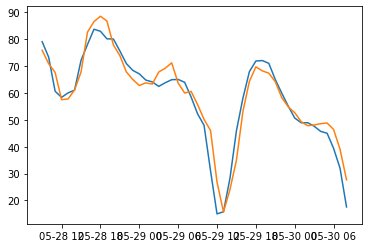

In [81]:
plt.plot(y_test)
plt.plot(y_test.index, pred)

In [82]:
y_test

time
2021-05-28 09:00:00    79.03
2021-05-28 10:00:00    73.29
2021-05-28 11:00:00    60.61
2021-05-28 12:00:00    58.34
2021-05-28 13:00:00    60.00
2021-05-28 14:00:00    61.02
2021-05-28 15:00:00    72.09
2021-05-28 16:00:00    77.99
2021-05-28 17:00:00    83.67
2021-05-28 18:00:00    82.90
2021-05-28 19:00:00    80.10
2021-05-28 20:00:00    80.03
2021-05-28 21:00:00    75.59
2021-05-28 22:00:00    70.89
2021-05-28 23:00:00    68.37
2021-05-29 00:00:00    67.07
2021-05-29 01:00:00    64.77
2021-05-29 02:00:00    64.09
2021-05-29 03:00:00    62.42
2021-05-29 04:00:00    63.77
2021-05-29 05:00:00    64.91
2021-05-29 06:00:00    65.00
2021-05-29 07:00:00    63.94
2021-05-29 08:00:00    58.47
2021-05-29 09:00:00    52.20
2021-05-29 10:00:00    47.96
2021-05-29 11:00:00    31.03
2021-05-29 12:00:00    15.01
2021-05-29 13:00:00    15.83
2021-05-29 14:00:00    28.27
2021-05-29 15:00:00    45.95
2021-05-29 16:00:00    58.05
2021-05-29 17:00:00    67.90
2021-05-29 18:00:00    71.85
2021-05-2

## Sequential predict

On prédit sur la prediction précédente sur n_frames

In [87]:
lags_features = [_ for _ in data.columns if _.startswith('t_')]

In [128]:
data = data.drop(labels=["month", "weekend", "hour_sin", "hour_cos"], axis=1)

In [164]:
n_frames=24

#idx = int(len(data)*0.4)
idx = 15000
x_train = data[:idx].drop("value", axis=1)
y_train = data[:idx]["value"]

x_test = data[idx:].drop("value", axis=1)
y_test = data[idx:]["value"]

In [165]:
data.shape

(26112, 169)

In [175]:
n_frames=24
n_days = 30

n_hours_forecast = n_frames*n_days
pred_period = np.zeros((n_days, n_frames))

#idx = int(len(data)*0.4)
idx = 15000
x_train = data[:idx].drop("value", axis=1)
y_train = data[:idx]["value"]

x_test = data[idx:].drop("value", axis=1)
y_test = data[idx:]["value"]

input_tmp = []
lgbm = LGBMRegressor()

for i, n in enumerate(range(0, n_hours_forecast, n_frames)):
    # every n_frames we init forecaster with known values prices
    x_input = x_test.iloc[n].values
    print(x_train.shape)
    lgbm.fit(x_train, y_train)
    
    pred_day = []
    
    for _ in range(0, n_frames):
        if _ !=0:
            lags_features = [_ for _ in x_test.columns if _.startswith('t_')]
            other_columns = [_ for _ in x_test.columns if _ not in lags_features]
            
            tmp_lags = x_test[lags_features].iloc[n+_].values
            tmp_static = x_test[other_columns].iloc[n+_].values

            # we replace past day prices with forecasted ones
            tmp_lags[:_] = pred_day[::-1][:_]
            
            x_input = np.concatenate((tmp_lags, tmp_static), axis=0)
        #print(f"{x_test.iloc[n+_].name} : {x_input}")
        input_tmp.append(x_input)
        
        last_pred = lgbm.predict(x_input.reshape(1, -1))
        
        pred_day.append(last_pred[0])
    
    pred_period[i,:] = pred_day
        
    x_train = data[:idx+n].drop('value', axis=1)
    y_train = data[:idx+n]['value']

y_test = data[idx:idx+(n*_)+1]['value']

(15000, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15000, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15024, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15048, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15072, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15096, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15120, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15144, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15168, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15192, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15216, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15240, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15264, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15288, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15312, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15336, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15360, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15384, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15408, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15432, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15456, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15480, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15504, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15528, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15552, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15576, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15600, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15624, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15648, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


(15672, 168)


/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


In [176]:
x_test.head()

,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,...,t_159,t_160,t_161,t_162,t_163,t_164,t_165,t_166,t_167,t_168
time,,,,,,,,,,,,,,,,,,,,,
2020-09-24 00:00:00,28.44,29.95,32.45,39.02,49.89,53.01,60.80,56.43,54.93,42.18,...,42.00,45.80,53.91,59.69,53.64,48.00,36.56,34.58,34.32,34.73
2020-09-24 01:00:00,26.47,28.44,29.95,32.45,39.02,49.89,53.01,60.80,56.43,54.93,...,39.89,42.00,45.80,53.91,59.69,53.64,48.00,36.56,34.58,34.32
2020-09-24 02:00:00,22.26,26.47,28.44,29.95,32.45,39.02,49.89,53.01,60.80,56.43,...,39.07,39.89,42.00,45.80,53.91,59.69,53.64,48.00,36.56,34.58
2020-09-24 03:00:00,19.08,22.26,26.47,28.44,29.95,32.45,39.02,49.89,53.01,60.80,...,37.10,39.07,39.89,42.00,45.80,53.91,59.69,53.64,48.00,36.56
2020-09-24 04:00:00,26.55,19.08,22.26,26.47,28.44,29.95,32.45,39.02,49.89,53.01,...,36.66,37.10,39.07,39.89,42.00,45.80,53.91,59.69,53.64,48.00


In [177]:
input_tmp

[array([ 28.44,  29.95,  32.45,  39.02,  49.89,  53.01,  60.8 ,  56.43,
         54.93,  42.18,  43.46,  43.58,  41.33,  43.94,  48.92,  48.94,
         52.56,  58.32,  53.21,  51.92,  39.52,  37.12,  38.45,  39.71,
         41.08,  43.51,  40.55,  50.19,  55.47,  70.  ,  86.4 ,  70.  ,
         58.92,  53.93,  48.32,  42.71,  43.26,  44.95,  48.02,  52.05,
         61.85,  73.09,  72.89,  52.97,  44.16,  41.03,  40.61,  42.05,
         43.17,  42.93,  48.73,  54.67,  62.52,  98.13, 200.04,  90.81,
         65.  ,  56.  ,  50.96,  44.01,  40.98,  44.25,  48.13,  54.4 ,
         72.09,  85.  ,  73.19,  54.36,  43.11,  36.07,  35.54,  35.6 ,
         35.46,  37.24,  38.31,  44.65,  47.9 ,  51.91,  51.7 ,  46.47,
         38.31,  34.2 ,  32.95,  32.34,  31.02,  31.13,  31.34,  34.2 ,
         36.75,  35.05,  34.5 ,  34.8 ,  34.2 ,  34.21,  34.4 ,  35.36,
         36.77,  37.89,  36.71,  39.74,  44.41,  51.05,  51.02,  47.95,
         40.7 ,  34.99,  32.41,  30.72,  30.73,  31.67,  32.56, 

In [178]:
pred_period.ravel().shape

(720,)

In [179]:
30*24

720

In [180]:
y_test[:n_hours_forecast].shape

(720,)

In [201]:
y_test

time
2020-09-24 00:00:00    26.47
2020-09-24 01:00:00    22.26
2020-09-24 02:00:00    19.08
2020-09-24 03:00:00    26.55
2020-09-24 04:00:00    39.18
                       ...  
2020-10-23 19:00:00    35.84
2020-10-23 20:00:00    38.45
2020-10-23 21:00:00    36.58
2020-10-23 22:00:00    29.84
2020-10-23 23:00:00    31.94
Name: value, Length: 720, dtype: float64

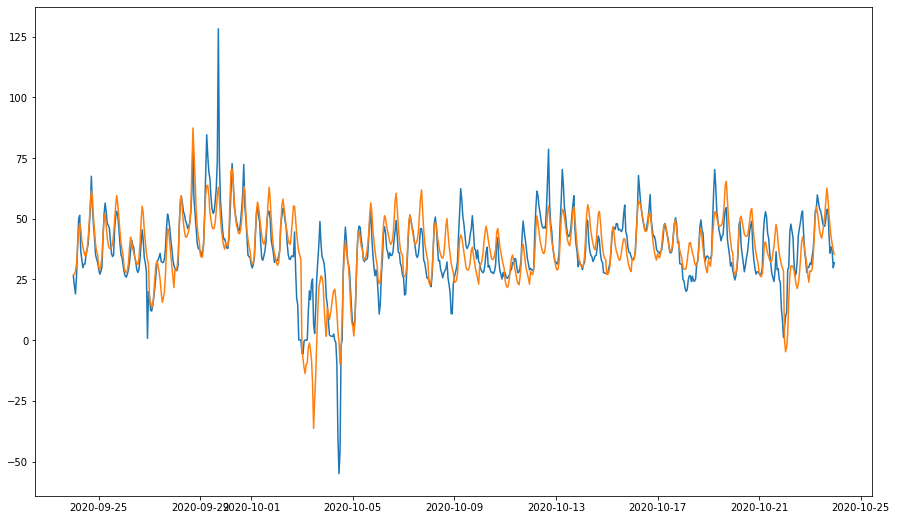

In [202]:
plt.figure(figsize=(15, 9))
n_day_forecast = 720
plt.plot(y_test[:n_hours_forecast])
plt.plot(y_test[:n_hours_forecast].index, pred_period.ravel()[:n_hours_forecast])

In [203]:
x_test

,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,...,t_159,t_160,t_161,t_162,t_163,t_164,t_165,t_166,t_167,t_168
time,,,,,,,,,,,,,,,,,,,,,
2020-09-24 00:00:00,28.44,29.95,32.45,39.02,49.89,53.01,60.80,56.43,54.93,42.18,...,42.00,45.80,53.91,59.69,53.64,48.00,36.56,34.58,34.32,34.73
2020-09-24 01:00:00,26.47,28.44,29.95,32.45,39.02,49.89,53.01,60.80,56.43,54.93,...,39.89,42.00,45.80,53.91,59.69,53.64,48.00,36.56,34.58,34.32
2020-09-24 02:00:00,22.26,26.47,28.44,29.95,32.45,39.02,49.89,53.01,60.80,56.43,...,39.07,39.89,42.00,45.80,53.91,59.69,53.64,48.00,36.56,34.58
2020-09-24 03:00:00,19.08,22.26,26.47,28.44,29.95,32.45,39.02,49.89,53.01,60.80,...,37.10,39.07,39.89,42.00,45.80,53.91,59.69,53.64,48.00,36.56
2020-09-24 04:00:00,26.55,19.08,22.26,26.47,28.44,29.95,32.45,39.02,49.89,53.01,...,36.66,37.10,39.07,39.89,42.00,45.80,53.91,59.69,53.64,48.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,32.49,40.01,60.97,62.23,20.49,25.49,10.02,10.01,10.05,0.93,...,125.31,135.00,162.22,184.07,157.15,180.25,248.85,274.33,267.03,250.00
2021-12-31 20:00:00,0.18,32.49,40.01,60.97,62.23,20.49,25.49,10.02,10.01,10.05,...,128.03,125.31,135.00,162.22,184.07,157.15,180.25,248.85,274.33,267.03
2021-12-31 21:00:00,0.08,0.18,32.49,40.01,60.97,62.23,20.49,25.49,10.02,10.01,...,142.46,128.03,125.31,135.00,162.22,184.07,157.15,180.25,248.85,274.33


In [182]:
pred_period

array([[ 27.00267849,  27.04817454,  28.45707948,  31.46859239,
         38.23907722,  45.48114266,  48.1290084 ,  46.06988262,
         40.83468212,  38.37278957,  36.40791203,  34.77213447,
         34.71770371,  37.22135368,  42.23807557,  48.50646856,
         56.00018476,  61.45450312,  58.88848688,  50.3159356 ,
         44.79963915,  39.37085587,  36.55976866,  35.03313991],
       [ 30.18252373,  28.89947775,  30.68885683,  34.14649915,
         43.14531446,  50.07018282,  52.21427341,  47.365924  ,
         42.36361855,  39.20481612,  37.90174294,  37.65940396,
         38.32927082,  39.56099504,  43.67420228,  49.86680312,
         55.4764007 ,  59.55456774,  55.85093638,  50.34760962,
         44.8387293 ,  40.31042885,  37.38109707,  34.87701696],
       [ 29.76908919,  28.42246248,  27.85924521,  28.53112885,
         31.54446704,  37.94780471,  42.4346346 ,  41.05081099,
         37.88430187,  36.06044407,  34.43325735,  32.58532134,
         31.30108581,  31.22065158,  3

In [199]:
np.sqrt(mean_squared_error(y_test[:stop], pred_period.ravel()[:stop]))

9.758493933207845

In [200]:
mean_absolute_error(y_test[:stop], pred_period.ravel()[:stop])

6.900800456456106

https://www.cienciadedatos.net/documentos/py42-forecasting-prediction-intervals-machine-learning.html

https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html

### Ridge

In [331]:
n_frames=24
idx = 15000
x_train = data[:idx].drop("value", axis=1)
y_train = data[:idx]["value"]

x_test = data[idx:].drop("value", axis=1)
y_test = data[idx:]["value"]

In [332]:
x_test.shape

(2353, 172)

In [333]:
pred_ridge = []
idx_init = x_test.index[0]
n_day_forecast = n_frames*30
for n in range(0, n_day_forecast, n_frames):
    last_pred = x_test.iloc[n]
    ridge.fit(x_train, y_train)
    for _ in range(0, n_frames):
        if _ !=0:
            lags_features = [_ for _ in x_test.columns if _.startswith('t_')]
            other_columns = [_ for _ in x_test.columns if _ not in lags_features]
            
            tmp = x_test[lags_features].iloc[n+_]
            tmp = tmp.shift(1)
            tmp.iloc[0] = last_pred
            last_pred = pd.concat([tmp, x_test.iloc[n+_][other_columns]], axis=0)
            
        last_pred = ridge.predict(last_pred.values.reshape(1, -1))
        pred_ridge.extend(last_pred)
    x_train = data[:idx+n].drop('value', axis=1)
    y_train = data[:idx+n]['value']

y_test = data[idx:idx+n+_+1]['value']

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

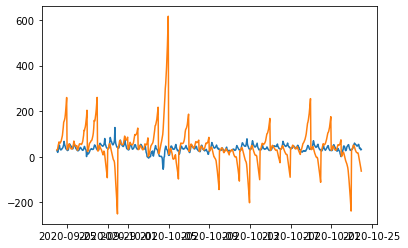

In [334]:
plt.plot(y_test)
plt.plot(y_test.index, pred_ridge)

In [335]:
np.sqrt(mean_squared_error(y_test, pred_ridge))

80.34470494034673

#### Current

In [145]:
current.train_model(y_train)

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)

KeyboardInterrupt



In [147]:
data.shape

(26112, 169)

In [183]:
%%time
#idx = int(len(data)*0.4)
idx = 15000
x_train = data[:idx].drop("value", axis=1)
y_train = data[:idx]["value"]

x_test = data[idx:].drop("value", axis=1)
y_test = data[idx:]["value"]

pred_current = []
n_frames = 24
n_days = 30
n_hours_forecast = n_frames*n_days

for n in range(n_frames, n_hours_forecast+1, n_frames):
    current.train_model(y_train)
    pred_current.extend(current.forecast(n_frames=n_frames))
    y_train = data[:idx+n]['value']
y_test = data[idx:idx+n]['value']

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_mo

CPU times: user 1h 1min 45s, sys: 3h 17min 48s, total: 4h 19min 33s
Wall time: 17min 6s


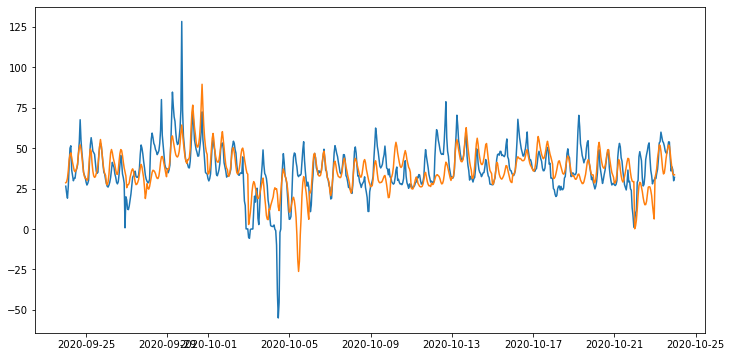

In [184]:
plt.figure(figsize=(12, 6))
plt.plot(y_test)
plt.plot(y_test.index, pred_current)

In [157]:
np.sqrt(mean_squared_error(y_test, pred_current))

7.922874818774123

In [158]:
mean_absolute_error(y_test, pred_current)

5.714239011703886

In [208]:
s = "hyuiode_9789.xlsx"
s[:-5][-4:]

'9789'

In [204]:
with open("reports/pred_arima_v0.pkl", "wb") as f_out:
    pickle.dump(pd.Series(pred_current, index=y_test.index), f_out)

In [195]:
import pickle

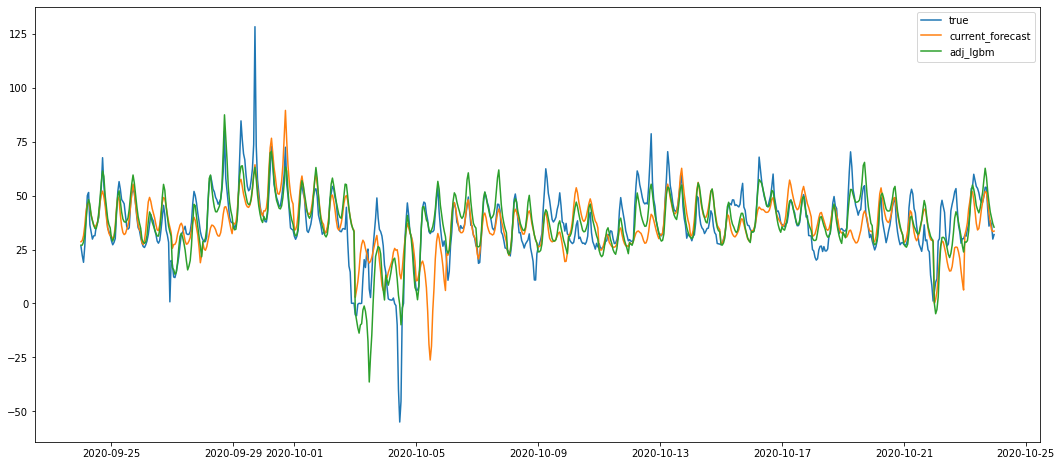

In [186]:
plt.figure(figsize=(18, 8))
plt.plot(y_test, label="true")
plt.plot(y_test.index, pred_current, label="current_forecast")
#plt.plot(y_test.index, pred_lgbm, label="lgbm_forecast")
plt.plot(y_test.index, pred_period.ravel(), label="adj_lgbm")
#plt.scatter(np.arange())

plt.legend()

In [189]:
print(mean_absolute_error(y_test, pred_current))
print(mean_absolute_error(y_test, pred_period.ravel()))

9.226865913418361
6.900800456456106


In [192]:
f"{100-(mean_absolute_error(y_test, pred_period.ravel())/mean_absolute_error(y_test, pred_current))*100:.2f} % better perf"

'25.21 % better perf'

In [193]:
f"{14*60/15} x better timing"

'56.0 x better timing'

In [51]:
# sampler for train and test sets
sampler = SamplerSetForecast(df=prices, 
                            n_frames=config_exp["n_frames"],
                            )
sampler.init_train_test_set(
    date_start=config_exp["date_start"],
    date_end=config_exp["date_end"],
    )

17533


In [52]:
timedelta(hours=24)

datetime.timedelta(days=1)

In [53]:
sampler.x_train[sampler.x_train.isna()]

Series([], Name: value, dtype: float64)

In [199]:
%%time
n_frames=24
init_idx = 15000
idx = init_idx

pred_ridge = []
pred_lgbm = []
for i in range(1, 10):
    x_train = data[:idx].drop("value", axis=1)
    y_train = data[:idx]["value"]
    x_test = data[idx:(idx+n_frames)].drop("value", axis=1)
    y_test = data[idx:(idx+n_frames)]["value"]
    
    lgbm.fit(x_train, y_train)
    ridge.fit(x_train, y_train)
    
    pred_lgbm.extend(lgbm.predict(x_test))
    pred_ridge.extend(ridge.predict(x_test))
    idx = idx + n_frames

x_test = data[init_idx:idx].drop("value", axis=1)
y_test = data[init_idx:idx]['value']

CPU times: user 1min 12s, sys: 9.49 s, total: 1min 21s
Wall time: 5.21 s


In [201]:
x_test

,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,...,t_163,t_164,t_165,t_166,t_167,t_168,weekend,month,hour_sin,hour_cos
time,,,,,,,,,,,,,,,,,,,,,
2020-09-24 00:00:00,28.44,29.95,32.45,39.02,49.89,53.01,60.80,56.43,54.93,42.18,...,53.64,48.00,36.56,34.58,34.32,34.73,0,9,0.000000e+00,1.000000
2020-09-24 01:00:00,26.47,28.44,29.95,32.45,39.02,49.89,53.01,60.80,56.43,54.93,...,59.69,53.64,48.00,36.56,34.58,34.32,0,9,2.697968e-01,0.962917
2020-09-24 02:00:00,22.26,26.47,28.44,29.95,32.45,39.02,49.89,53.01,60.80,56.43,...,53.91,59.69,53.64,48.00,36.56,34.58,0,9,5.195840e-01,0.854419
2020-09-24 03:00:00,19.08,22.26,26.47,28.44,29.95,32.45,39.02,49.89,53.01,60.80,...,45.80,53.91,59.69,53.64,48.00,36.56,0,9,7.308360e-01,0.682553
2020-09-24 04:00:00,26.55,19.08,22.26,26.47,28.44,29.95,32.45,39.02,49.89,53.01,...,42.00,45.80,53.91,59.69,53.64,48.00,0,9,8.878852e-01,0.460065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-02 19:00:00,29.03,44.59,34.36,34.71,34.59,33.26,33.41,35.28,40.02,46.95,...,28.03,30.71,34.01,35.12,39.82,46.03,0,10,-8.878852e-01,0.460065
2020-10-02 20:00:00,17.36,29.03,44.59,34.36,34.71,34.59,33.26,33.41,35.28,40.02,...,26.39,28.03,30.71,34.01,35.12,39.82,0,10,-7.308360e-01,0.682553
2020-10-02 21:00:00,14.56,17.36,29.03,44.59,34.36,34.71,34.59,33.26,33.41,35.28,...,25.94,26.39,28.03,30.71,34.01,35.12,0,10,-5.195840e-01,0.854419


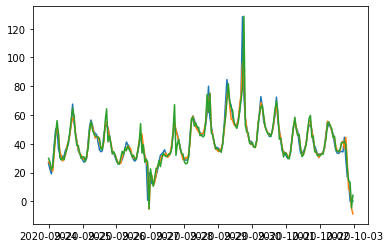

In [200]:
plt.plot(y_test)
plt.plot(y_test.index, pred_lgbm)
plt.plot(y_test.index, pred_ridge)

* On ne peut pas connaitre le x_test ! (les differents lag en avance)

In [202]:
print(mean_squared_error(y_test, pred_lgbm))
print(mean_squared_error(y_test, pred_ridge))

22.99965346832825
51.04181435022356


In [38]:
y_true

,value
time,
2021-01-01 13:00:00,44.73
2021-01-01 14:00:00,46.59
2021-01-01 15:00:00,52.99
2021-01-01 16:00:00,60.26
2021-01-01 17:00:00,60.61
2021-01-01 18:00:00,60.36
2021-01-01 19:00:00,57.40
2021-01-01 20:00:00,53.86
2021-01-01 21:00:00,53.45


In [417]:
datetime.date(2021, 1, 1)

TypeError: descriptor 'date' for 'datetime.datetime' objects doesn't apply to a 'int' object

### Exponential smoothing

In [515]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [516]:
x_train

,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,...,t_163,t_164,t_165,t_166,t_167,t_168,weekend,month,hour_sin,hour_cos
time,,,,,,,,,,,,,,,,,,,,,
2019-01-08 00:00:00,17.94,1.84,20.82,32.04,40.96,42.05,47.91,53.42,53.26,53.25,...,-17.25,-12.55,-7.41,-9.91,-4.08,10.07,0,1,0.000000,1.000000
2019-01-08 01:00:00,20.91,17.94,1.84,20.82,32.04,40.96,42.05,47.91,53.42,53.26,...,-15.07,-17.25,-12.55,-7.41,-9.91,-4.08,0,1,0.269797,0.962917
2019-01-08 02:00:00,7.78,20.91,17.94,1.84,20.82,32.04,40.96,42.05,47.91,53.42,...,-4.93,-15.07,-17.25,-12.55,-7.41,-9.91,0,1,0.519584,0.854419
2019-01-08 03:00:00,14.33,7.78,20.91,17.94,1.84,20.82,32.04,40.96,42.05,47.91,...,-6.33,-4.93,-15.07,-17.25,-12.55,-7.41,0,1,0.730836,0.682553
2019-01-08 04:00:00,18.56,14.33,7.78,20.91,17.94,1.84,20.82,32.04,40.96,42.05,...,-4.93,-6.33,-4.93,-15.07,-17.25,-12.55,0,1,0.887885,0.460065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-12 01:00:00,45.88,47.24,43.46,46.40,44.93,44.99,49.20,48.59,51.51,45.00,...,28.76,23.35,22.09,18.37,22.04,24.12,1,1,0.269797,0.962917
2019-01-12 02:00:00,44.61,45.88,47.24,43.46,46.40,44.93,44.99,49.20,48.59,51.51,...,36.63,28.76,23.35,22.09,18.37,22.04,1,1,0.519584,0.854419
2019-01-12 03:00:00,42.90,44.61,45.88,47.24,43.46,46.40,44.93,44.99,49.20,48.59,...,40.46,36.63,28.76,23.35,22.09,18.37,1,1,0.730836,0.682553


In [ ]:
n_frames=24
idx = 10000
data_cut = prices[:15000]
x_train = data_cut[:idx].drop("value", axis=1)
y_train = data_cut[:idx]["value"]

x_test = data_cut[idx:].drop("value", axis=1)
y_test = data_cut[idx:]["value"]

In [517]:
prices.shape

(26280, 2)

In [518]:
x_test.shape

(2353, 172)

In [519]:
data.shape

(17353, 173)

In [521]:
x_train.shape

(102, 172)

In [605]:
exp_model = ExponentialSmoothing(endog=y_train, trend="add", seasonal_periods=7, )
exp_model_fit = exp_model.fit(optimized=True)
pred = exp_model_fit.predict(len(x_train), len(x_train)+n_frames)

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [606]:
y_test[:n_frames]

time
2020-09-24 00:00:00    26.47
2020-09-24 01:00:00    22.26
2020-09-24 02:00:00    19.08
2020-09-24 03:00:00    26.55
2020-09-24 04:00:00    39.18
2020-09-24 05:00:00    49.97
2020-09-24 06:00:00    51.46
2020-09-24 07:00:00    36.45
2020-09-24 08:00:00    33.01
2020-09-24 09:00:00    29.84
2020-09-24 10:00:00    31.35
2020-09-24 11:00:00    31.42
2020-09-24 12:00:00    35.79
2020-09-24 13:00:00    37.43
2020-09-24 14:00:00    39.76
2020-09-24 15:00:00    46.84
2020-09-24 16:00:00    53.93
2020-09-24 17:00:00    67.57
2020-09-24 18:00:00    54.94
2020-09-24 19:00:00    47.63
2020-09-24 20:00:00    42.01
2020-09-24 21:00:00    35.09
2020-09-24 22:00:00    33.34
2020-09-24 23:00:00    31.92
Name: value, dtype: float64

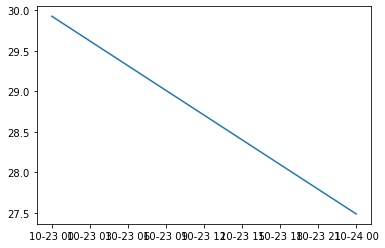

In [607]:
#plt.plot(y_test[:n_frames])
plt.plot(pred)